In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

%matplotlib inline

### Загрузка, обзор данных

In [2]:
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')

In [3]:
def save_prepared_data(df, name):
    df.to_csv(f'./data/prepared_{name}.csv', index=False)

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Глобальные переменные**

In [5]:
home_own = 'Home Ownership' # домовладение
ann_income = 'Annual Income' # годовой доход
years_on_job = 'Years in current job' # количество лет на текущем месте работы
tax_liens = 'Tax Liens' # налоговые льготы
numb_accounts = 'Number of Open Accounts' # количество открытых счетов
years_cred_hist = 'Years of Credit History' # количество лет кредитной истории
max_credit = 'Maximum Open Credit' # наибольший открытый кредит
cred_problems = 'Number of Credit Problems' # количество проблем с кредитом
months_last_delinq = 'Months since last delinquent' # количество месяцев с последней просрочки платежа
bancrupcies = 'Bankruptcies' # банкротства
purpose = 'Purpose' # цель кредита
term = 'Term' # срок кредита
cur_loan_amount = 'Current Loan Amount' # текущая сумма кредита
cur_cred_bal = 'Current Credit Balance' # текущий кредитный баланс
month_debt = 'Monthly Debt' # ежемесячный долг
cred_score = 'Credit Score' # ???
cred_default = 'Credit Default' # факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Обработка пропусков**

In [6]:
def print_na(df):
    print(len(df) - df.count())
    
print_na(data_train)

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64


In [7]:
def fill_annual_income(df):
    df[ann_income] = df[ann_income].fillna(df[ann_income].mean())
    return df

In [8]:
def fill_years_cur_job(df):
    df[years_on_job] = df[years_on_job].fillna(df[years_on_job].mode()[0])
    return df

In [9]:
def fill_months_last_del(df):
    df[months_last_delinq] = df[months_last_delinq].fillna(df[months_last_delinq].mean())
    return df

In [10]:
def fill_bankruptcies(df):
    df[bancrupcies] = df[bancrupcies].fillna(df[bancrupcies].mean())
    return df

In [11]:
def fill_na(df):
    df = fill_annual_income(df)
    df = fill_years_cur_job(df)
    df = fill_months_last_del(df)
    df = fill_bankruptcies(df)
    return df

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
def prepare_data(df):
    df = df.copy()
    df = fill_na(df)
    df = df.select_dtypes(include=numerics)
    df = df.dropna()
    return df

In [13]:
train_prepared = prepare_data(data_train)

**Отбор признаков**

In [14]:
TARGET_NAME = cred_score
FEATURE_NAMES_SELECTED = train_prepared.columns.drop([TARGET_NAME, cred_default]).tolist()

In [15]:
def plot_corr(features):
    corr_with_target = train_prepared[features + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

    plt.title('Correlation with target variable')
    plt.show()

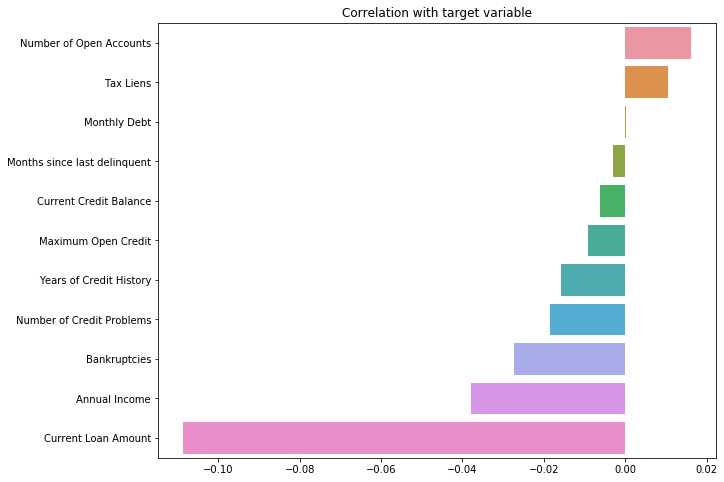

In [16]:
plot_corr(FEATURE_NAMES_SELECTED)

**Нормализация данных**

In [17]:
def normalize(df):
    scaler = StandardScaler()

    df_norm = df.copy()
    df_norm[FEATURE_NAMES_SELECTED] = scaler.fit_transform(df_norm[FEATURE_NAMES_SELECTED])

    return df_norm.copy()

In [18]:
# train_prepared = normalize(train_prepared)

**Разбиение test и train**

In [19]:
def split(df):
    X = df[FEATURE_NAMES_SELECTED]
    y = df[TARGET_NAME]

    return train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [20]:
X_train, X_test, y_train, y_test = split(train_prepared)

### CatBoost

**Подбор гиперпараметров**

In [21]:
model_catb = catb.CatBoostRegressor(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

In [22]:
def get_prediction(ds, y=None, r2=False):
    pred = model_catb.predict(ds)
    if r2:
        print('R2:', r2_score(y, pred))
    return pred

In [23]:
get_prediction(X_train, y_train, True)

R2: 0.28001766577533527


array([ 694.39623629, 1274.89108283,  785.56445819, ...,  681.63304932,
       1018.73942315,  940.53185989])

In [24]:
get_prediction(X_test, y_test, True)

R2: 0.0022908111723767277


array([1297.13070046,  967.27039553, 1138.31655741, ...,  942.02378121,
       1062.92909343,  570.7191387 ])

In [25]:
y_test.head()

557      707.0
3872     722.0
6933    7340.0
6047     684.0
2173     740.0
Name: Credit Score, dtype: float64

In [26]:
feat_imp = pd.DataFrame({'feat': FEATURE_NAMES_SELECTED, 'importance': model_catb.get_feature_importance()})
feat_imp.sort_values('importance', ascending=False).head(10)

,feat,importance
8,Current Loan Amount,15.566127
3,Years of Credit History,14.510693
0,Annual Income,14.470064
9,Current Credit Balance,11.984990
10,Monthly Debt,11.391321
4,Maximum Open Credit,11.244786
2,Number of Open Accounts,8.894617
6,Months since last delinquent,8.764797
7,Bankruptcies,1.676965
1,Tax Liens,0.784482


In [27]:
with open('./data/credit_score_reg', 'wb') as file:
    pickle.dump(model_catb, file)